In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.vision import *
from fastai.data_block import *
from fastai.basic_train import *
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable
import pandas as pd

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
import psycopg2

conn = psycopg2.connect(host="dbinstance.c6phnxzyppjs.us-west-2.rds.amazonaws.com",
                        database="muimui", user="marwa", password="muimuidb")
cur = conn.cursor()
cur.execute('SELECT id from products where is_nsfw=0')
listings = cur.fetchall()
listings = [str(x[0]) for x in listings]

In [5]:
def imread(fname):
    return Image.open(fname)

totensor = transforms.ToTensor()

In [6]:
class VAEImageItemList(ImageList):
    def __init__(self, items:Iterator, log:bool=False, **kwargs):
        if isinstance(items, ItemList):
            self.items = items.items
        super(ImageList,self).__init__(items,**kwargs)

    def get(self, i):
        fname = str(self.items[i])
        x = imread(fname)
        x = totensor(x)
        return x

In [7]:
def get_y_fn(fn):
    x = imread(fn)
    x = totensor(x)
    return x

In [8]:
p = Path('../product_resized/')
img_fns = list(p.iterdir())

In [9]:
img_fns_filtered = [x for x in img_fns if str(x).split('/')[-1].split('.')[0] in listings]

In [10]:
len(img_fns)

30368

In [11]:
len(img_fns_filtered)

28180

In [12]:
img_fns_filtered_rand = list(np.array(img_fns_filtered)[np.array(np.random.choice(range(len(img_fns_filtered)), 
                                                5000, replace=False))])

In [13]:
len(img_fns_filtered_rand)

5000

In [14]:
x_il = VAEImageItemList(ItemList(img_fns_filtered_rand))
# test_ds = VAEImageItemList(ItemList(img_fns_filtered[:500]))

In [15]:
x_ils = x_il.random_split_by_pct(0.1)

In [16]:
# lls = x_ils.label_from_lists(x_ils.train, x_ils.valid)
lls = x_ils.label_from_func(get_y_fn)

In [17]:
db = lls.databunch(bs=12)

In [16]:
# train_ds = VAEDataset('/content/drive/My Drive/test')
# sz = 512
# batch_size = 4

In [24]:
# m(Variable(x).cuda()).size()

## Decoder

In [18]:
m = vision.models.resnet34(pretrained = True).cuda()
m = nn.Sequential(*list(m.children())[:-2], nn.Conv2d(512, 4, 1).cuda())

class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)
    
add_layer(m,4,128,'Upsample0')
add_layer(m,128,64,'Upsample1',out_shape=(128,128),scale=None)
add_layer(m,64,32,'Upsample2')
add_layer(m,32,3,'Upsample3',act='sig')

In [24]:
# m(Variable(x).cuda()).size()

In [34]:
# encoder = nn.Sequential(*list(m.children())[:9])

In [26]:
# del encoder

In [27]:
# encoder(Variable(x).cuda()).size()

In [28]:
# data = ImageDataBunch.from_csv('../', 'kaggle_resized', label_delim=',', bs=64,
#                                valid_pct=0.1, csv_labels='MC.csv' ,label_col='cats')

In [19]:
learn = Learner(db, m.cuda(),loss_func=F.mse_loss)

In [20]:
# learn.data.train_dl=train_loader
# learn.data.test_dl = test_loader

In [21]:
learn.model.cuda();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


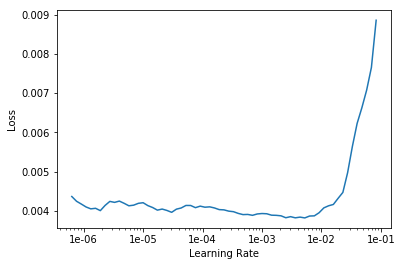

In [22]:
learn.load('AE_stage2_fast_ai')
# learn.dl = db
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [28]:
lr = 1*1e-3
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,0.003698,0.004061,01:28
1,0.003991,0.004087,01:28
2,0.003965,0.004312,01:28
3,0.003858,0.004192,01:28
4,0.003593,0.004147,01:28
5,0.003747,0.003970,01:28
6,0.003675,0.003910,01:29
7,0.003511,0.003847,01:29
8,0.003557,0.003917,01:29
9,0.003497,0.003846,01:28


In [54]:
learn.save('AE_stage2_fast_ai')

In [29]:
t,_ = next(iter(db.dl()))

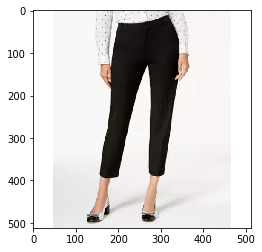

In [30]:
plt.imshow(t[7].cpu().transpose(0, 2).transpose(0,1).data.numpy())

In [31]:
pred = m(t)

In [32]:
pred.shape

torch.Size([12, 3, 512, 512])

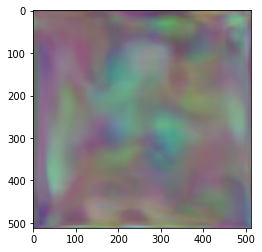

In [33]:
plt.imshow(pred[7].cpu().transpose(0, 2).transpose(0,1).data.numpy())

In [65]:
encoding = {}

for fname in db.train_ds.items:
    data = get_y_fn(fname)
    data = data.unsqueeze(0).cuda()
    encoding[str(fname).split('/')[-1].split('.')[0]] = encoder(data).data.cpu().numpy().reshape(-1, 4*16*16)


In [92]:
fname

PosixPath('../product_resized/9526.jpg')

In [66]:
len(encoding)

4500

In [83]:
vals = [x[0] for x in  list(encoding.values())]

In [85]:
len(vals)

4500

In [86]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 5
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(vals)

In [88]:
distances, indices = nbrs.kneighbors(vals[10].reshape(1,-1))


In [89]:
indices

array([[  10, 3180, 2975, 1697,  355]])

In [91]:
list(encoding.keys())[10]

'27144'

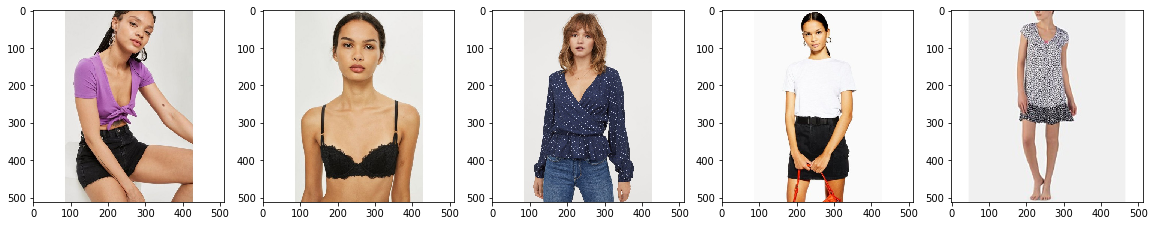

In [93]:
i=2
plt.figure(figsize=(24, 8))
ax = plt.subplot(1, n_neigh+1, 1)
# plt.imshow(t[10].cpu().transpose(0, 2).transpose(0,1).data.numpy())
plt.imshow(imread('../product_resized/'+list(encoding.keys())[10]+'.jpg'))
for name in indices[0][1:]:
    ax = plt.subplot(1, n_neigh+1, i)
    plt.imshow(imread('../product_resized/'+list(encoding.keys())[name]+'.jpg'))
    i+=1

array([PosixPath('../product_resized/9521.jpg'), PosixPath('../product_resized/10131.jpg'),
       PosixPath('../product_resized/14480.jpg'), PosixPath('../product_resized/14354.jpg'), ...,
       PosixPath('../product_resized/834.jpg'), PosixPath('../product_resized/29825.jpg'),
       PosixPath('../product_resized/10477.jpg'), PosixPath('../product_resized/9526.jpg')], dtype=object)